## `multi_cauchy`: a library for fitting hysteresis curves and their derivatives to an arbitrary number of Cauchy CDFs or PDFs 

### CDF:

$ M(H, M_s, H_c, \gamma) = \chi_{pd}H + \sum_1^n \frac{2M_{s,n}}{\pi} \arctan{\frac{H-H_{c,n}}{\gamma_n}}  $

### PDF:

$ \frac{dM}{dH}(H, M_s, H_c, \gamma) = \chi_{pd} + \sum_1^n \frac{8M_{s,n}}{\pi} \frac{\gamma_n}{16 (H-H_{c,n})^2 + \gamma_n^2 } $

[PDF adapted from Vasquez, C.A., Fazzito, S.Y. Simple hysteresis loop model for rock magnetic analysis. Stud Geophys Geod 64, 114–129 (2020)](https://doi.org/10.1007/s11200-019-1942-8)

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import multi_cauchy as mc

### Import Files into `MvsHFile` objects

Contains the following attributes:

- `path`: file path
- `header`: information stored in the file header
- `sample_info`: a dictionary containing information on the sample mass, eicosane mass, molecular weight, and diamagnetic correction. Default loading of the file checks the following lines of the .dat file:
    - "SAMPLE_MASS" --> `sample_info["mass"]`
    - "SAMPLE_VOLUME" --> `sample_info["eicosane_mass"]`
    - "SAMPLE_MOLECULAR_WEIGHT" --> `sample_info["molecular_weight"]`
    - "SAMPLE_SIZE" --> `sample_info["diamagnetic_correction"]`
- `data`:  a `pd.DataFrame` containing the following columns:
    - "time"
    - "temperature"
    - "field" - note: in Oe
    - "uncorrected_moment_emu" - either from "DC Moment Free Center (emu)" or "Moment (emu)" depending on whether the measurement was dc or VSM
    - "uncorrected_moment_error"
    - "moment_emu" - corrected for diamagnetism if `sample_info["diamagnetic_correction"] exists, otherwise is the same as "uncorrected_moment_emu"
    - "moment" - in units of $\mu_B$ if `sample_info["diamagnetic_correction"]` and `sample_info["molecular_weight"]` exists, otherwise is equal to `uncorrected_moment_emu`
    - "normalized_moment" - all files will create this column regardless of values for other columns
- `temperatures` - a list of the temperatures at which M vs H measurements in the file were collected

In [2]:
sample = Path(".") / "sample_files"
angelica3 = mc.MvsHFile(sample / "201201 - [Er_TIPS2COT_I]3 - 2 - 1 - MvsH.dat" ) # 3

In [3]:
file = angelica3
file.temperatures

[2.0]

In [4]:
file.data

,time,temperature,field,uncorrected_moment_emu,uncorrected_moment_error,moment_emu,moment,normalized_moment
0,3.815951e+09,1.999939,69999.632812,0.651303,0.000504,0.651920,14.682627,0.972266
1,3.815951e+09,1.999911,69999.578125,0.650937,0.000347,0.651554,14.674378,0.971720
2,3.815951e+09,2.000133,69743.375000,0.651449,0.000457,0.652063,14.685862,0.972481
3,3.815951e+09,2.000031,69289.984375,0.651693,0.000683,0.652303,14.691253,0.972838
4,3.815951e+09,2.000044,69245.406250,0.651531,0.000509,0.652141,14.687608,0.972596
...,...,...,...,...,...,...,...,...
1119,3.815957e+09,1.999945,69003.335938,0.651450,0.000617,0.652058,14.685736,0.972472
1120,3.815957e+09,2.000065,69254.867188,0.651117,0.000486,0.651727,14.678284,0.971979
1121,3.815957e+09,2.000147,69501.234375,0.650631,0.000466,0.651243,14.667376,0.971257
1122,3.815957e+09,1.999953,69752.710938,0.651059,0.000440,0.651673,14.677078,0.971899


### Quickly inspect the data in an `MvsHFile` with `mc.plot_mvsh(file: MvsHFile)`

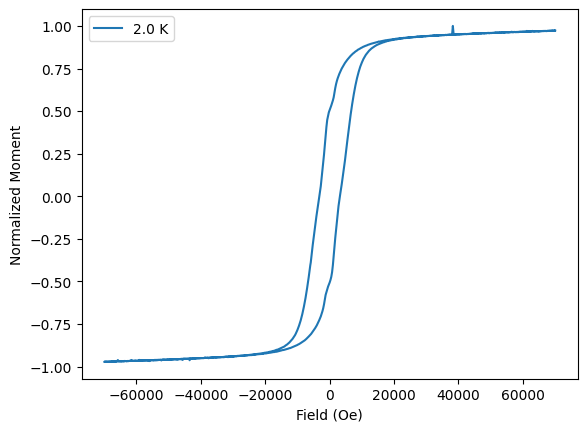

In [5]:
fig, ax = mc.plot_mvsh(file)

### Select the measurement you wish to investigate by creating an `MvsHMeasurement` object

Contains the following attributes:

- `file` - the parent `MvsHFile` object
- `temperature_index` - the index of the `MvsHFile.temperatures` of the measurement under closer investigation
- `temperature` - the actual temperature of the measuremnt under investigation
- `data` - just the data of the measurement under investigation
- `virgin`, `reverse`, `forward` - each attribute contains the data found in virgin, reverse, and forward scans
- `sweep_rate`, `sweep_rate_std` - the average and standard deviation of the sweep rate

In [6]:
meas = mc.MvsHMeasurement(file,0)

### Fitting step 1: find some useful input parameters

The fitting functions we'll use later are very dependent on starting parameters, particularly $H_c$.

Use `mc.quick_find_peaks()` to quickly explore the $dM/dH$ data to find where there should be a Cauchy terms.

`mc.quick_find_peaks()` condenses three processes:

1. differentiation - "deriv_method" processes the data using either:
    - "diff": `data["normalized_moment"].diff()/data["field"].diff()`, or
    - "gradient": `np.gradient(data["normalized_moment"], data["field"])`
2. smoothing:
    - "smoothing_window_type" defaults to "boxcar" and also accepts "triang" (and probably works with some other window types)
    - "smoothing_window_fn" applies either a mean or median filter
    - "smoothing_window_size" defaults to 3, accepts any odd integer
3. peak finding
    - uses `scipy.find_peaks()`
    - "find_peaks_args" takes a dictionary which passes arguments to `scipy.find_peaks()`
    - most commonly used modifications include "height", "distance", "width"
    
`mc.quick_find_peaks()` returns a list of peaks and the figure/axes to show what it did

[-1492.04553222656, 1252.74133300781, 5864.71142578125]

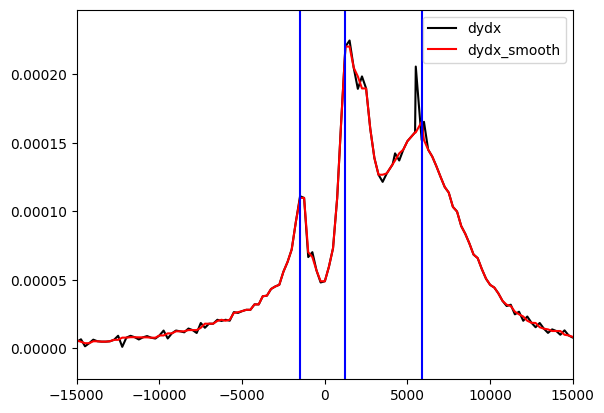

In [7]:
peaks, fig, ax = mc.quick_find_peaks(
    meas,
    # deriv_method="gradient",
    # smoothing_window_fn="median",
    # smoothing_window_size=5,
    # find_peaks_args={"distance": 20}
)
ax.set_xlim(-15000, 15000)
peaks

### Use the info from the peak finding to create input parameters in the form of a list of `mc.CauchyParams` objects

`CauchyParams` take three arguments representing starting values for $M_s$, $H_c$, and $\gamma$.

Alternatively you can provide a 3-tuple containing the starting value with min and max constraints

In [8]:
temp_peaks = peaks.copy()
temp_peaks.append(3000)
params = []
for peak in temp_peaks:
    gamma = 500
    params.append(mc.CauchyParams(1/len(peaks), peak, gamma))

### Fit the Cauchy CDF and PDF (separately, for now)

`mc.fit_multi_cauchy_cdf()` arguments:
    - "measurement" - the `MvsHMeasurement` object
    - "cauchy_params" - the list of `CauchyParams` objects you provide as starting values. The length of this list determines how many terms the fit will use
    - "sequence" - defaults to "both" which fits both forward and reverse sequences, but also accepts "forward" or "reverse" to fit just one of the sequences
    
`mc.fit_multi_cauchy_cdf()` uses [the `lmfit` library for least squares minimization](https://lmfit.github.io/lmfit-py/fitting.html). The magic of the function is that you can request to fit an arbitrary number of Cauchy terms and the objective function will change accordingly. 

`mc.fit_multi_acuhy_cdf()` returns a [`MinimizerResults` object from `lmfit.minimizer`](https://lmfit.github.io/lmfit-py/fitting.html#lmfit.minimizer.MinimizerResult). The most useful attribute of this object is `params` 

#### Quickly look at the fit results using `mc.plot_cdf_fit()`

The residual plotted at the bottom is a normlized residual.

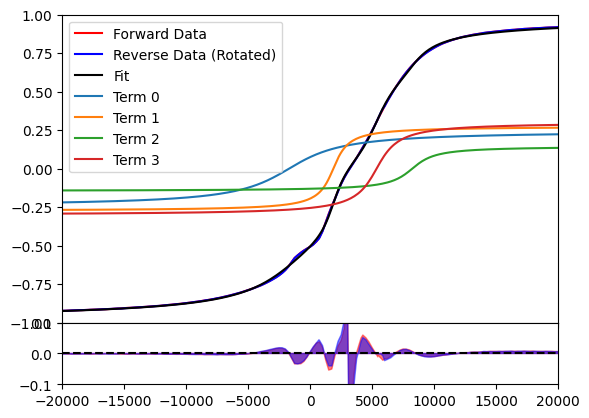

In [9]:
cdf_out = mc.fit_multi_cauchy_cdf(meas, params, sequence = "both")
fig, axs = mc.plot_cdf_fit(meas, cdf_out, sequence = "both")

`mc.fit_multi_cauchy_pdf()` behaves mostly the same as the CDF version

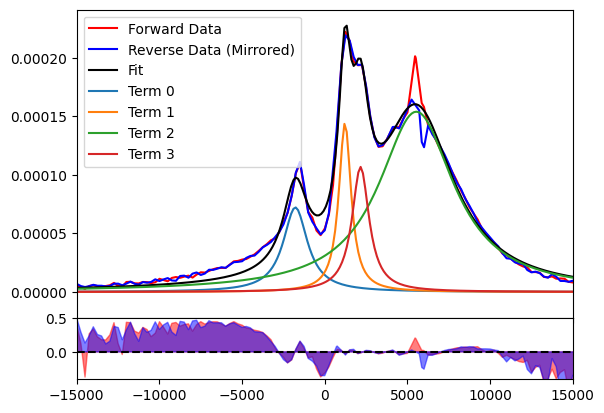

In [10]:
pdf_out = mc.fit_multi_cauchy_pdf(meas, params, sequence = "both")
fig, axs = mc.plot_pdf_fit(meas, pdf_out, sequence = "both")
# axs[1].set_xlim(-70000,70000)

### Record the results of this analysis in a report which collates all analyses on a given file

`mc.write_report()` records the results of analyses in a .json file which defaults to the same location as the original data file. 

`mc.ingest_report()` takes this .json file and creates a `ReportFile` object with composite `ReportMeasurement` objects. The intention is to make it easy to analyze, for example, the temperature dependence of a particular Cauchy term, after you have fit all of the temperature scans in a give file.

The .json report also includes all information needed to reproduce the analyses. 

In [11]:
mc.write_report(file, meas, params, cdf_out, pdf_out)

A measurement with the same temperature and number of terms already exists in multi_cauchy_201201 - [Er_TIPS2COT_I]3 - 2 - 1 - MvsH. Do you want to (1) overwrite it, (2) keep both, or (3) cancel this report? [1/2/3] 3
